In [1]:
import mlflow
import nltk
import string
import re
import unicodedata
import spacy 

import numpy as np
import pandas as pd
from functools import partial
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from catboost import Pool, CatBoostClassifier

from datasets import load_dataset

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word("#cool!"))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [4]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [5]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [6]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    # text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying to seduce me arent you'

In [7]:
df = load_dataset("MoritzLaurer/sentiment_economy_news")

In [8]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'labels', 'articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'],
        num_rows: 382
    })
    train_sample: Dataset({
        features: ['text', 'labels', 'articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'],
        num_rows: 1000
    })
    train_sample_numeric: Dataset({
        features: ['text', 'labels', 'articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'],
        num_rows: 1000
    })
})

In [9]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"{'>>' * 20} info {'<<' * 20}")
        print(f"split: {example['split']} | idx: {example['idx']} | articleid: {example['articleid']}")
        print(f"labels: {example['labels']} | positivity: {example['positivity']} | "
              f"positivity_rounded: {example['positivity_rounded']} | relevance: {example['relevance']}'")
        print(f"{'>>' * 20} text {'<<' * 20}")
        print(f"'{example['text']}'")
        print('=' * 90)
        print()


show_samples(df)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> info <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
split: train | idx: 2342 | articleid: 123268813
labels: positive | positivity: 6.0 | positivity_rounded: 6.0 | relevance: yes'
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> text <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
'THE ECONOMIC SCENE: The Recovery Still Lives. Little wonder the stock market has been bounding up and down like a yoryo lately. There are so many anomalies in the economic picture these days and so much uncertainty over what lies aheadr-for domestic business, inflation. Government Policies; ehersv ahd taxation as well as over the whole international pic* ture—that no one seems to have much reliance on aiiy forecasts, whatever they predict.</br></br>One week, or even a single day, produces reasons for cheer, but the very next period uncovers contrary data or assessments to chase the euphoria. Investors, like businessmen, don't know what to expect next.</br></br>Although the economy seldom m

In [10]:
df.set_format("pandas")

In [11]:
df_train = df['train'][:]
df_val = df['test'][:]

In [12]:
df_train.head()

,text,labels,articleid,relevance,positivity,split,positivity_rounded,idx
0,Fed Finds Slow Pace Of Growth: Floods and Drou...,positive,109090677,yes,6.666666666666667,train,7.0,0
1,Boca Raton is a town that has everything -- in...,negative,108871079,yes,3.0,train,3.0,1
2,U.S. ADDS PROGRAMS WITH LITTLE REVIEW OF LOCAL...,negative,108967205,yes,2.5,train,2.0,2
3,"UNEMPLOYMENT UP TO 9.8% FOR JULY, A POSTWAR RE...",negative,122035424,yes,2.6666666666666665,train,3.0,3
4,Battered Dollar's Future: Domestic Politics As...,negative,119448747,yes,4.0,train,4.0,4


In [13]:
df_train['labels'].unique()

array(['positive', 'negative'], dtype=object)

In [14]:
df_val['labels'].unique()

array(['negative', 'positive'], dtype=object)

In [15]:
df_test = pd.read_csv("../data/external/sentiment/Fin_Cleaned.csv")

In [16]:
df_test

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive
...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",Negative
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,Negative
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,Negative
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,Positive


In [17]:
df_test['Final Status'].unique()

array(['Negative', 'Positive', 'Positive '], dtype=object)

In [18]:
df_train['labels'] = df_train['labels'].apply(lambda x: 1 if x == 'positive' else 0)
df_val['labels'] = df_val['labels'].apply(lambda x: 1 if x == 'positive' else 0)

df_train.drop(
    columns=['articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'], 
    inplace=True)
df_val.drop(
    columns=['articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'], 
    inplace=True)

In [19]:
df_train.head()

,text,labels
0,Fed Finds Slow Pace Of Growth: Floods and Drou...,1
1,Boca Raton is a town that has everything -- in...,0
2,U.S. ADDS PROGRAMS WITH LITTLE REVIEW OF LOCAL...,0
3,"UNEMPLOYMENT UP TO 9.8% FOR JULY, A POSTWAR RE...",0
4,Battered Dollar's Future: Domestic Politics As...,0


In [20]:
df_test['text'] = df_test[['Headline', 'Full_text']].agg('. '.join, axis=1)
df_test['labels'] = df_test['Final Status'].apply(lambda x: 0 if x == 'Negative' else 1)

df_test.drop(
    columns=['Date_published', 'Headline', 'Synopsis', 'Full_text', 'Final Status'], 
    inplace=True)

In [21]:
df_test.head()

,text,labels
0,"Banks holding on to subsidy share, say payment...",0
1,Digitally ready Bank of Baroda aims to click o...,1
2,Karnataka attracted investment commitment of R...,1
3,Splitting of provident fund accounts may be de...,0
4,Irdai weighs proposal to privatise Insurance I...,1


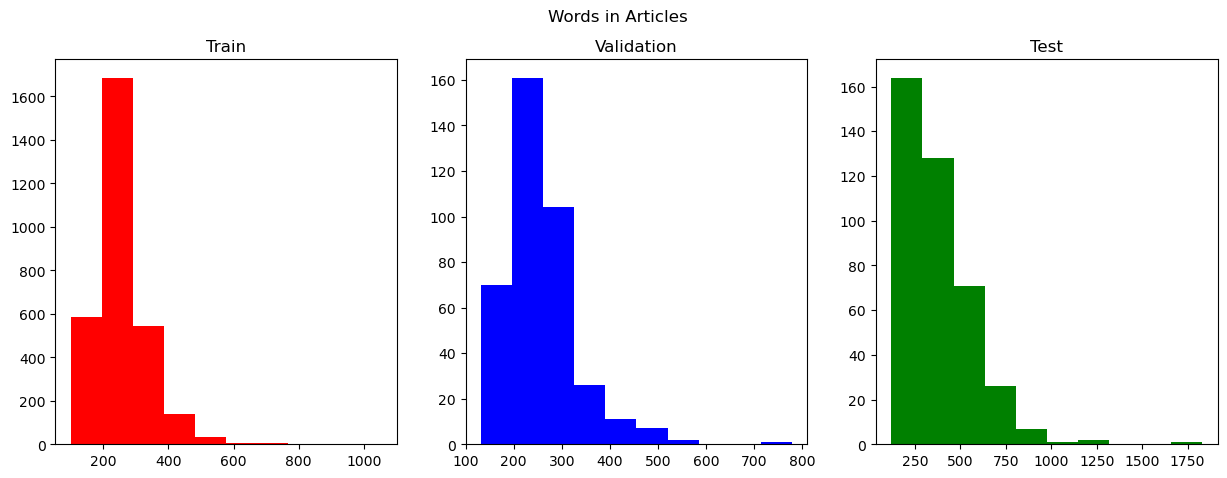

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

train_title_len=df_train['text'].str.split().map(len)
ax1.hist(train_title_len, color='red')
ax1.set_title('Train')

val_title_len=df_val['text'].str.split().map(len)
ax2.hist(val_title_len, color='blue')
ax2.set_title('Validation')

test_title_len=df_test['text'].str.split().map(len)
ax3.hist(test_title_len, color='green')
ax3.set_title('Test')

fig.suptitle('Words in Articles')
plt.show()

In [23]:
df_train['text'] = df_train['text'].apply(clean_text)
df_val['text'] = df_val['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

In [24]:
df_train.head()

,text,labels
0,fed finds slow pace of growth floods and droug...,1
1,boca raton is town that has everything includi...,0
2,us adds programs with little review of local b...,0
3,unemployment up to for july postwar record new...,0
4,battered dollars future domestic politics assu...,0


In [25]:
def remove_stopwords(text, use_stopwords=True):
    if not use_stopwords:
        return text
    stopwords_set = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in stopwords_set])


def apply_word_transform(text, transform_type=None):
    if transform_type == "stem_porter":
        stemmer = PorterStemmer()
        return ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(text)])
    elif transform_type == "stem_snowball":
        stemmer = SnowballStemmer(language='english')
        return ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(text)])
    elif transform_type == "lemm_nltk_wordnet":
        lemmatizer = WordNetLemmatizer()
        words = nltk.word_tokenize(text)
        return ' '.join([lemmatizer.lemmatize(word, pos = "v") for word in words])
    elif transform_type == "lemm_spacy_en_core_web_sm":
        spacy_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])
        doc = spacy_model(text)
        return ' '.join([token.lemma_ for token in doc])
    else:
        return text

In [26]:
mlflow.set_tracking_uri("http://mlflow:5000")

In [27]:
# List all experiments including deleted ones
experiments_info = mlflow.search_experiments(view_type=mlflow.entities.ViewType.ALL)
for experiment in experiments_info:
    print(f"ID: {experiment.experiment_id}, Name: {experiment.name}, Lifecycle Stage: {experiment.lifecycle_stage}")

ID: 1, Name: sentiment_model_catboost, Lifecycle Stage: active
ID: 0, Name: Default, Lifecycle Stage: active


In [28]:
mlflow.set_experiment("sentiment_model_catboost")

<Experiment: artifact_location='s3://styx-nlp-artifacts/1', creation_time=1714323194473, experiment_id='1', last_update_time=1714323194473, lifecycle_stage='active', name='sentiment_model_catboost', tags={}>

In [29]:
model_path = "sentiment-analysis/catboost/"

In [30]:
search_space = {
    'learning_rate': hp.loguniform('learning_rate', -4.6, 0),
    'iterations': hp.quniform('iterations', 100, 1000, 100),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 2, 30, 1),
    'depth': hp.quniform('depth', 4, 12, 1),
    # 'random_strength': hp.loguniform('random_strength', -20, 2.3),
    # 'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 1.0),
    # 'border_count': hp.quniform('border_count', 1, 255, 1),
    # 'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.0), 
    }

common_params = {
    'loss_function': 'Logloss',
    'eval_metric':'AUC',
    'early_stopping_rounds': 20,
    'random_seed': 42, 
    'verbose': 0,
    'task_type': 'CPU',
    'use_best_model': True
}

In [31]:
def objective(
    params, 
    common_params, 
    train_pool, 
    val_pool, 
    use_stopwords=False, 
    transform_type=None
):
    with mlflow.start_run(nested=True):  # Nested run for hyperparameter tuning

        model = CatBoostClassifier(**{**common_params, **params})
        model.fit(train_pool, eval_set=val_pool)
        score = model.get_best_score()['validation']['AUC']
        
        mlflow.log_params({
            "hyperparams": params,
            "use_stopwords": use_stopwords, 
            "transform_type": transform_type or "none"
        })
        mlflow.log_metric("AUC", score)
        
        return {'loss': -score, 'status': STATUS_OK}

In [32]:
stop_word_vars = [False, True]
word_transform_vars = [None, "stem_porter", "stem_snowball", "nltk_wordnet", "spacy_en_core_web_sm"]

for use_stopwords, transform_type in product(stop_word_vars, word_transform_vars):

    X_train, X_val, X_test = df_train[["text"]], df_val[["text"]], df_test[["text"]]
    y_train, y_val, y_test = df_train["labels"], df_val["labels"], df_test["labels"]

    X_train.loc[:, "text"] = X_train["text"].apply(
        lambda x: apply_word_transform(
            remove_stopwords(x, use_stopwords), transform_type
        )
    )
    X_val.loc[:, "text"] = X_val["text"].apply(
        lambda x: apply_word_transform(
            remove_stopwords(x, use_stopwords), transform_type
        )
    )
    X_test.loc[:, "text"] = X_test["text"].apply(
        lambda x: apply_word_transform(
            remove_stopwords(x, use_stopwords), transform_type
        )
    )

    train_pool = Pool(
        X_train, y_train, text_features=["text"], feature_names=list(X_train)
    )
    val_pool = Pool(X_val, y_val, text_features=["text"], feature_names=list(X_val))
    test_pool = Pool(X_test, y_test, text_features=["text"], feature_names=list(X_test))

    # Define and start a new run
    with mlflow.start_run():
        preprocess_comb = (
            f"use_stopwords={use_stopwords}, transform_type={transform_type}"
        )
        mlflow.log_param("Preprocessing", preprocess_comb)
        best = fmin(
            fn=partial(
                objective,
                common_params=common_params,
                train_pool=train_pool,
                val_pool=val_pool,
                use_stopwords=use_stopwords,
                transform_type=transform_type,
            ),
            space=search_space,
            algo=tpe.suggest,
            max_evals=30,
            trials=Trials(),
            show_progressbar=True,
        )

        best_params = space_eval(search_space, best)

        model = CatBoostClassifier(**{**common_params, **best_params})
        model.fit(train_pool, eval_set=val_pool)

        auc_train = roc_auc_score(
            df_train["labels"], model.predict_proba(train_pool)[:, 1])
        auc_val = roc_auc_score(
            df_val["labels"], model.predict_proba(val_pool)[:, 1])
        auc_test = roc_auc_score(
            df_test["labels"], model.predict_proba(test_pool)[:, 1])
        mlflow.log_metric("AUC Train", auc_train)
        mlflow.log_metric("AUC Validation", auc_val)
        mlflow.log_metric("AUC Test", auc_test)

        params_to_log = {
            key: str(value) for key, value in {**common_params, **best_params}.items()
        }
        mlflow.log_params(params_to_log)
        
        model.save_model("model.cbm")
        mlflow.log_artifact("model.cbm", "sentiment-analysis/catboost")

        print()
        print(preprocess_comb)
        print(
            f"ROC AUC Train: {np.round(auc_train * 100, 2)} | "
            f"ROC AUC Val: {np.round(auc_val * 100, 2)} | "
            f"ROC AUC Test: {np.round(auc_test * 100, 2)}"
        )
        print()


100%|██████████| 30/30 [10:53<00:00, 21.79s/trial, best loss: -0.7317618669256349]

use_stopwords=False, transform_type=None
ROC AUC Train: 91.77 | ROC AUC Val: 73.18 | ROC AUC Test: 60.23

100%|██████████| 30/30 [17:02<00:00, 34.08s/trial, best loss: -0.7514199111268062] 

use_stopwords=False, transform_type=stem_porter
ROC AUC Train: 90.66 | ROC AUC Val: 75.14 | ROC AUC Test: 59.53

100%|██████████| 30/30 [26:19<00:00, 52.66s/trial, best loss: -0.7358523880992319] 

use_stopwords=False, transform_type=stem_snowball
ROC AUC Train: 85.06 | ROC AUC Val: 73.59 | ROC AUC Test: 60.2

100%|██████████| 30/30 [21:04<00:00, 42.14s/trial, best loss: -0.7369412318648656]

use_stopwords=False, transform_type=nltk_wordnet
ROC AUC Train: 93.21 | ROC AUC Val: 73.69 | ROC AUC Test: 59.82

100%|██████████| 30/30 [12:43<00:00, 25.45s/trial, best loss: -0.7340572672964303] 

use_stopwords=False, transform_type=spacy_en_core_web_sm
ROC AUC Train: 90.41 | ROC AUC Val: 73.41 | ROC AUC Test: 61.32

100%|███

In [34]:
search_space = {
    'learning_rate': hp.loguniform('learning_rate', -4.6, 0),
    'iterations': hp.quniform('iterations', 100, 2000, 100),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 2, 30, 1),
    'depth': hp.quniform('depth', 4, 16, 1),
    'random_strength': hp.loguniform('random_strength', -20, 2.3),
    'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 1.0),
    'border_count': hp.quniform('border_count', 1, 255, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.0), 
    }

common_params = {
    'loss_function': 'Logloss',
    'eval_metric':'AUC',
    'early_stopping_rounds': 20,
    'random_seed': 42, 
    'verbose': 0,
    'task_type': 'CPU',
    'use_best_model': True
}

In [ ]:
stop_word_vars = [False]
word_transform_vars = ["spacy_en_core_web_sm"]

for use_stopwords, transform_type in product(stop_word_vars, word_transform_vars):

    X_train, X_val, X_test = df_train[["text"]], df_val[["text"]], df_test[["text"]]
    y_train, y_val, y_test = df_train["labels"], df_val["labels"], df_test["labels"]

    X_train.loc[:, "text"] = X_train["text"].apply(
        lambda x: apply_word_transform(
            remove_stopwords(x, use_stopwords), transform_type
        )
    )
    X_val.loc[:, "text"] = X_val["text"].apply(
        lambda x: apply_word_transform(
            remove_stopwords(x, use_stopwords), transform_type
        )
    )
    X_test.loc[:, "text"] = X_test["text"].apply(
        lambda x: apply_word_transform(
            remove_stopwords(x, use_stopwords), transform_type
        )
    )

    train_pool = Pool(
        X_train, y_train, text_features=["text"], feature_names=list(X_train)
    )
    val_pool = Pool(X_val, y_val, text_features=["text"], feature_names=list(X_val))
    test_pool = Pool(X_test, y_test, text_features=["text"], feature_names=list(X_test))

    # Define and start a new run
    with mlflow.start_run(run_name="Best of combinations"):
        preprocess_comb = (
            f"use_stopwords={use_stopwords}, transform_type={transform_type}"
        )
        mlflow.log_param("Preprocessing", preprocess_comb)
        best = fmin(
            fn=partial(
                objective,
                common_params=common_params,
                train_pool=train_pool,
                val_pool=val_pool,
                use_stopwords=use_stopwords,
                transform_type=transform_type,
            ),
            space=search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=Trials(),
            show_progressbar=True,
        )

        best_params = space_eval(search_space, best)

        model = CatBoostClassifier(**{**common_params, **best_params})
        model.fit(train_pool, eval_set=val_pool)

        auc_train = roc_auc_score(
            df_train["labels"], model.predict_proba(train_pool)[:, 1])
        auc_val = roc_auc_score(
            df_val["labels"], model.predict_proba(val_pool)[:, 1])
        auc_test = roc_auc_score(
            df_test["labels"], model.predict_proba(test_pool)[:, 1])
        mlflow.log_metric("AUC Train", auc_train)
        mlflow.log_metric("AUC Validation", auc_val)
        mlflow.log_metric("AUC Test", auc_test)

        params_to_log = {
            key: str(value) for key, value in {**common_params, **best_params}.items()
        }
        mlflow.log_params(params_to_log)
        
        model.save_model("model.cbm")
        mlflow.log_artifact("model.cbm", "sentiment-analysis/catboost")

        print()
        print(preprocess_comb)
        print(
            f"ROC AUC Train: {np.round(auc_train * 100, 2)} | "
            f"ROC AUC Val: {np.round(auc_val * 100, 2)} | "
            f"ROC AUC Test: {np.round(auc_test * 100, 2)}"
        )
        print()

  2%|▏         | 1/50 [02:44<2:14:29, 164.69s/trial, best loss: -0.6915923604367147]